In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import re

In [211]:
data = pd.read_csv('data.csv', encoding='gbk')

**观察数据的基本信息，包括样本数，样本维度，样本字段数据类型等，样本的部分数据**

In [212]:
data.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [213]:
data.shape

(4754, 90)

**样本数据主要为数值型数据和对象型数据**

In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

**观察object类型的数据：**

1. trade_no: 前面14位为年月日时分秒，后面的数字应该也可以分成2部分，最后一部分猜想应该是8位数字
2. bank_card_no: 银行卡号，暂时不知道有什么用
3. reg_preference_for_trad：城市类别（城市属于几线城市），对贷款是否逾期肯定有影响
4. source：不知道是什么数据
5. id_name: 用户姓名
6. latest_query_time: 最近一次查询时间
7. loans_latest_time: 最近一次贷款时间

**下一步细看一下这几个object类型数据的分布情况**

In [217]:
data[[column for column in data.columns if data[column].dtype == 'object']].head()

,trade_no,bank_card_no,reg_preference_for_trad,source,id_name,latest_query_time,loans_latest_time
0,20180507115231274000000023057383,卡号1,一线城市,xs,蒋红,2018-04-25,2018-04-19
1,20180507121002192000000023073000,卡号1,一线城市,xs,崔向朝,2018-05-03,2018-05-05
2,20180507125159718000000023114911,卡号1,一线城市,xs,王中云,2018-05-05,2018-05-01
3,20180507121358683000000388283484,卡号1,三线城市,xs,何洋洋,2018-05-05,2018-05-03
4,20180507115448545000000388205844,卡号1,一线城市,xs,赵洋,2018-04-15,2018-01-07


**观察trde_no的几部分数据：发现日期数据集中在3天，最后的9位数据较为分散，中间的9位数据类似正太分布**

In [218]:
last_non_zero_num_pattern = re.compile('\\d+0+([1-9]\\d{7,})$')
last_zero_num_pattern = re.compile('(\\d*?)0+$')

In [219]:
data_tmp = data[data['trade_no'].map(lambda x: last_non_zero_num_pattern.match(x) is not None)]['trade_no'].map(lambda x:last_non_zero_num_pattern.match(x).group(1))

In [224]:
np.max(data_tmp.map(lambda x:len(x)))

9

In [225]:
data['data_date'] = data['trade_no'].map(lambda x: x[:8])
data['trade_no_last9'] = data['trade_no'].map(lambda x:x[-9:])
data['trade_no_midle9'] = data['trade_no'].map(lambda x:x[14:23])

In [226]:
pd.value_counts(data['data_date'])

20180507    3682
20180504    1062
20180508      10
Name: data_date, dtype: int64

In [227]:
pd.value_counts(data['trade_no_last9'])

388345361    1
021287256    1
388431612    1
388385411    1
023098447    1
381786522    1
388237731    1
023087884    1
388278985    1
381769923    1
023051077    1
023090121    1
388410596    1
021252295    1
023059617    1
388266174    1
381520847    1
381704707    1
388198609    1
021245005    1
021240566    1
021219712    1
388388219    1
388322534    1
023111328    1
388250928    1
388356604    1
023114602    1
381726692    1
023057722    1
            ..
381597756    1
388296788    1
388200085    1
388328774    1
381883597    1
021175145    1
388369452    1
388328363    1
388392626    1
381504894    1
023060608    1
388253257    1
388250824    1
023055446    1
388338009    1
388237914    1
388303489    1
388379212    1
388391420    1
388224175    1
388228723    1
388240259    1
381688153    1
388235138    1
388180458    1
388295914    1
381603604    1
388241317    1
388299994    1
021223068    1
Name: trade_no_last9, Length: 4754, dtype: int64

In [228]:
pd.value_counts(data['trade_no_midle9'])

968000000    13
912000000    12
048000000    12
910000000    12
406000000    12
060000000    11
583000000    11
740000000    10
903000000    10
715000000    10
434000000    10
776000000    10
116000000    10
571000000    10
228000000    10
296000000    10
471000000    10
797000000    10
976000000    10
066000000    10
788000000    10
242000000    10
808000000     9
929000000     9
738000000     9
399000000     9
775000000     9
170000000     9
772000000     9
339000000     9
             ..
730000000     1
061000000     1
204000000     1
466000000     1
894000000     1
140000000     1
278000000     1
181000000     1
669000000     1
926000000     1
001000000     1
773000000     1
100000000     1
390000000     1
520000000     1
895000000     1
196000000     1
276000000     1
138000000     1
273000000     1
313000000     1
385000000     1
796000000     1
851000000     1
884000000     1
457000000     1
110000000     1
821000000     1
722000000     1
272000000     1
Name: trade_no_midle9, L

**将trade_no_midle9 处理成整形数字**

In [229]:
len_digit = np.max(data['trade_no_midle9'].map(lambda x:len(last_zero_num_pattern.match(x).group(1))).values)
data['trade_no_midle9'] = data['trade_no_midle9'].map(lambda x:int(int(x)/10**(9-len_digit)))

In [230]:
data['trade_no_midle9'].describe()

count    4754.000000
mean      503.149769
std       290.479038
min         0.000000
25%       250.250000
50%       504.000000
75%       759.000000
max       999.000000
Name: trade_no_midle9, dtype: float64

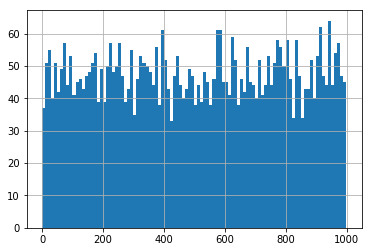

In [231]:
data['trade_no_midle9'].hist(bins=100)

**bank_card_no就一种数据，没有价值，需要去掉**

In [232]:
pd.value_counts(data['bank_card_no'])

卡号1    4754
Name: bank_card_no, dtype: int64

**reg_preference_for_trad: 城市类别，价值较大，可以考虑one-hot编码**

In [233]:
pd.value_counts(data['reg_preference_for_trad'])

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

**source数据较为分散，没有价值**

In [234]:
pd.value_counts(data['source'])

xs    4754
Name: source, dtype: int64

**用户名称，重名的较少，也不确定是否是同一个人，感觉应该不是同一个人。应该是无效数据，可以考虑去掉**

In [235]:
np.sum(pd.value_counts(data['id_name']).map(lambda x:x>=2).values)

131

**最近一次贷款时间和最近一次查询时间，感觉他们的时间差才有价值。**

In [236]:
data['loans_latest_time'].describe()

count           4457
unique           232
top       2018-05-03
freq             134
Name: loans_latest_time, dtype: object

In [237]:
pd.to_datetime(data['loans_latest_time']).head()

0   2018-04-19
1   2018-05-05
2   2018-05-01
3   2018-05-03
4   2018-01-07
Name: loans_latest_time, dtype: datetime64[ns]

In [240]:
miss_values_table.loc['latest_query_time']

Missing Values       304.0
% of Total Values      6.4
Name: latest_query_time, dtype: float64

In [241]:
miss_values_table.loc['loans_latest_time']

Missing Values       297.0
% of Total Values      6.2
Name: loans_latest_time, dtype: float64

In [242]:
data2 = data[data['loans_latest_time'].notna() & data['latest_query_time'].notna()]

In [243]:
data2['time_delta'] = (pd.to_datetime(data2['latest_query_time']) - pd.to_datetime(data2['loans_latest_time'])).map(lambda x: x.days)

/Users/benjamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [244]:
data2.shape

(4431, 94)

In [245]:
data2.drop(['Unnamed: 0','student_feature', 'bank_card_no', 'source', 'id_name', 'trade_no', 'latest_query_time', 'loans_latest_time', 'trade_no_last9'], axis=1, inplace=True)

/Users/benjamin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [272]:
data2 = data2[data2['data_date'].notna() & data2['reg_preference_for_trad'].notna()]

In [299]:
data2.shape

(4429, 91)

In [292]:
data2[[column for column in data2.columns if data2[column].dtype == 'object']].head()

,reg_preference_for_trad,data_date
0,一线城市,20180507
1,一线城市,20180507
2,一线城市,20180507
3,三线城市,20180507
4,一线城市,20180507


**给object对象编码**

In [293]:
data2 = pd.get_dummies(data2, prefix=['city', 'date'])

**填充缺失值, 将数据集切分成训练集和测试集**

In [303]:
imputer = Imputer()
Y = data2['status'].values
X = data2.drop(['status'], axis=1).values
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=2018)

In [312]:
train_x = imputer.fit_transform(train_x)
test_x = imputer.transform(test_x)

In [314]:
train_x

array([[3.216103e+06, 1.000000e-02, 8.200000e-01, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [2.872906e+06, 1.000000e-02, 9.900000e-01, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.909460e+05, 3.000000e-02, 9.700000e-01, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [1.624804e+06, 1.000000e-02, 7.800000e-01, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [2.425578e+06, 2.000000e-02, 9.800000e-01, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.369004e+06, 1.000000e-02, 6.600000e-01, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00]])

In [37]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

观察缺失值，发现student_feature这个字段的缺失值占比高达63%，数据太不可靠了，所以可以舍弃掉。

其他缺失数据的字段通过均值或中值策略进行补充

In [239]:
miss_values_table = missing_values_table(data)
miss_values_table.head()

Your selected dataframe has 93 columns.
There are 74 columns that have missing values.


,Missing Values,% of Total Values
student_feature,2998,63.1
cross_consume_count_last_1_month,426,9.0
query_cash_count,304,6.4
latest_six_month_apply,304,6.4
latest_one_month_apply,304,6.4
